# Notebook for Predicting House Prices

## Importing the important libraries

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split

# Regressors
import optuna
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score

# Pipelines and Utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import uniform, randint, loguniform

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("Full traning dataset shape is {}".format(df.shape))
print("Full test dataset shape is {}".format(test_df.shape))

Full traning dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# checking for null value count
df[df.columns[df.isnull().any()]].isnull().sum() 

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Droping PoolQC because of too many missing values.
Id is a irralavent feature

In [6]:
to_drop = ['PoolQC','Id']
df = df.drop(columns= to_drop).reset_index(drop= True)
X_kaggle_df = test_df.drop(columns= to_drop).reset_index(drop= True)
X_kaggle_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,120,0,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,144,0,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,MnPrv,Shed,700,7,2006,WD,Normal


Filling of missing value with mean or median or mode for numerical variable will we done after splitting the data to avoid data Leakage and estimating a Genuiene score.

In [7]:
df.dtypes.value_counts()

object     42
int64      34
float64     3
Name: count, dtype: int64

In [8]:
num_corr = df.select_dtypes(['int64','float64']).corr()
low_num_corr = num_corr['SalePrice'][abs(num_corr['SalePrice'] ) < 0.1]
low_num_corr

MSSubClass     -0.084284
OverallCond    -0.077856
BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
PoolArea        0.092404
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
Name: SalePrice, dtype: float64

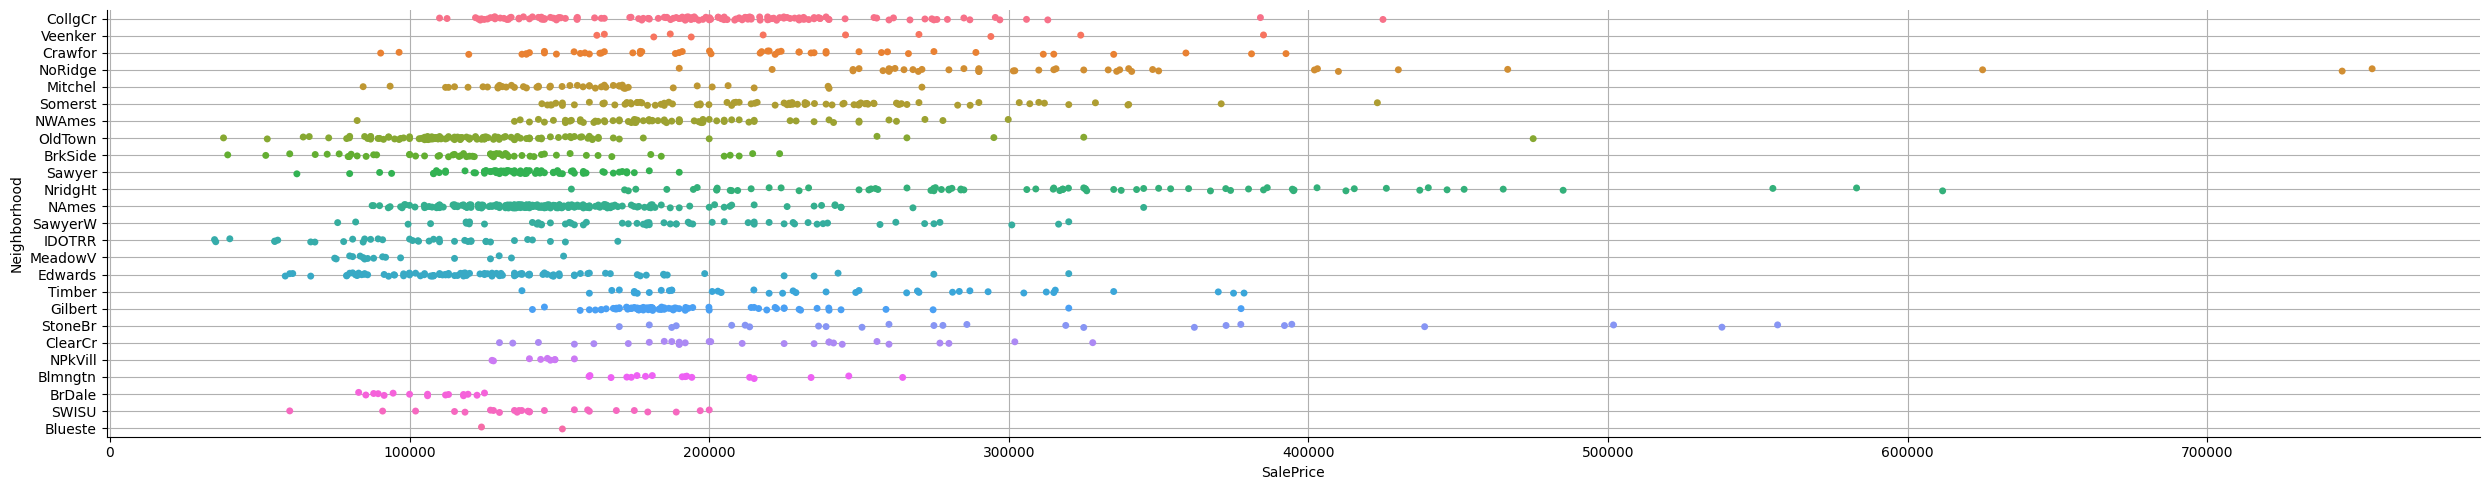

In [9]:
sns.catplot(y = df['Neighborhood'] ,x = df['SalePrice'], hue = df['Neighborhood'],aspect=5)
plt.tight_layout()
plt.grid()
plt.show()

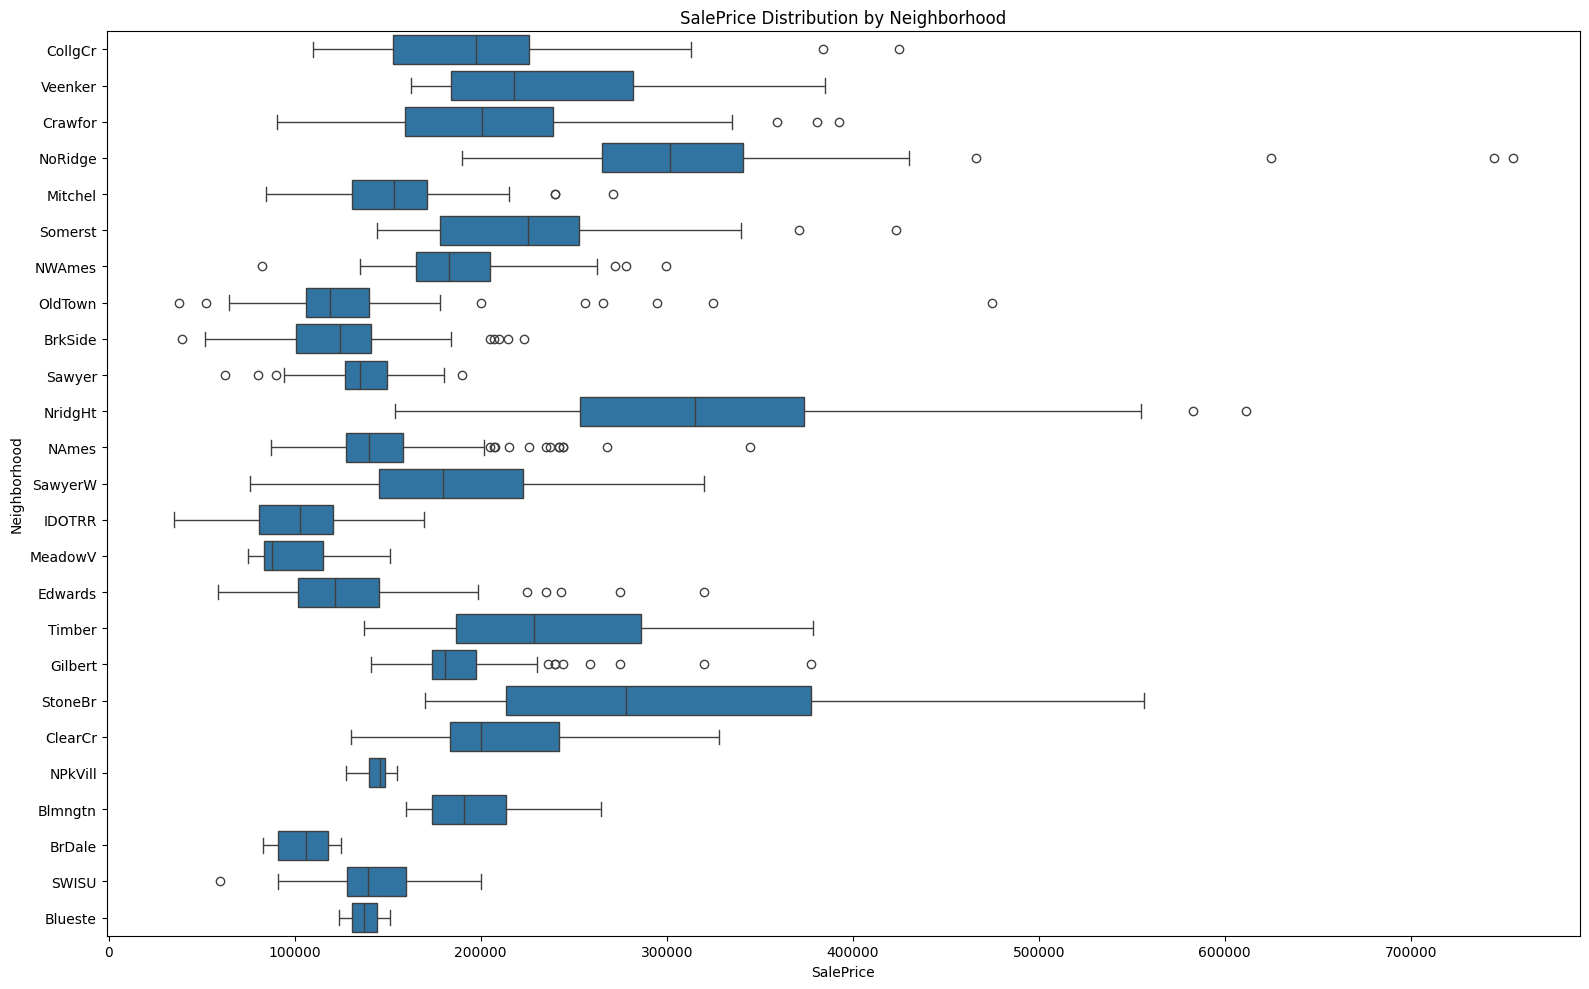

In [10]:
plt.figure(figsize=(16, 10))
sns.boxplot(y='Neighborhood', x='SalePrice', data=df, orient='h')
plt.title("SalePrice Distribution by Neighborhood")
plt.tight_layout()
plt.show()

##### Though both catplot and boxplot we can see NoRidge has some major outliners and bottom 3 catagory Neighborhood seems to have pricing below 200000

Let's see some statistical data for the Target(SalePrice).

In [11]:
#statistical parameters
from IPython.display import display

mean_price = df['SalePrice'].mean()
median_price = df['SalePrice'].median()
mode_price = df['SalePrice'].mode()[0]
std_price = df['SalePrice'].std()
var_price = df['SalePrice'].var()
min_price = df['SalePrice'].min()
max_price = df['SalePrice'].max()
range_price = max_price - min_price
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)
iqr = q3 - q1
skewness = df['SalePrice'].skew()
kurtosis = df['SalePrice'].kurt()

stats = ({
     'statistics':[
         'Mean', 'Median', 'Mode', 'Standard Deviation','Variance',
                   'Minimum','Maximum', 'Range','Q1 (25th percentile)', 'Q3 (75th percentile)',
                   'IQR','Skewness','Kurtosis'
                   ],
     'Value':[
         mean_price,median_price,mode_price,std_price,var_price,
         min_price,max_price,range_price, q1, q3, iqr , skewness, kurtosis
         ]
})
stats_table = pd.DataFrame(stats)
display(stats_table)

,statistics,Value
0,Mean,1.809212e+05
1,Median,1.630000e+05
2,Mode,1.400000e+05
3,Standard Deviation,7.944250e+04
4,Variance,6.311111e+09
5,Minimum,3.490000e+04
6,Maximum,7.550000e+05
7,Range,7.201000e+05
8,Q1 (25th percentile),1.299750e+05
9,Q3 (75th percentile),2.140000e+05


Median(1.630000e+05 ) is less than Mean (1.809212e+05) and skewness is equal to 1.8 which indicates positive skewness. Also Range is 7.201000e+05 which is large. in addition, kurtosis is equal to 6, which is called lepokurtic. in conclusion, these three parameters indicate the existence of outliers. so in the following we detect outliers to manage them.

#### Note: Removing Outliniears just because their value is very high or low is dangerous as it may can remove critical data like spike in sale and other things.

In [12]:
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)] 

In [13]:
print(f"UpperBound: {upper_bound}")
print(f"LowerBound: {lower_bound}")
print(f"No. of Outliers: {len(outliers)}")
print(f"Outliers Enfluence as a wholesum: {(outliers['SalePrice'].sum())/df['SalePrice'].sum()}")
print(f"Outliers Enfluence as a amount in the dataset: {(len(outliers))/len(df)}")

UpperBound: 340037.5
LowerBound: 3937.5
No. of Outliers: 61
Outliers Enfluence as a wholesum: 0.09836722372874777
Outliers Enfluence as a amount in the dataset: 0.04178082191780822


We can see 61 values are quite large or low compare to the other. There total sales influence is about 10% of the total sales(Need envestigation here) but there influence as an amount is just about 4% and since we usually take 5% on the signifiance so if they are legit sales we can leave them be. Just needed to check wheather they are legit or not. They are just p-values(Enfluence calculation) 

In [14]:
def bin_outliers(df, col,
                 bin_size=100_000,
                 iqr_multiplier=1.5,
                 skew_threshold=0.75):
    df = df.copy()
    
    # check skew and choose working col
    skew_val = df[col].skew()
    print(f"Skewness of '{col}': {skew_val:.3f}")
    if skew_val > skew_threshold:
        print(f"➡ applying log1p on '{col}' for better identifying the Outliners")
        df['_work'] = np.log1p(df[col])
        back_transform = np.expm1
    else:
        print(f" using raw '{col}'")
        df['_work'] = df[col]
        back_transform = lambda x: x

    # build clean bin edges (floor → ceil)
    col_min = df[col].min()
    col_max = df[col].max()
    floor = (int(col_min) // bin_size) * bin_size
    ceil  = ((int(col_max) + bin_size - 1) // bin_size) * bin_size

    edges = list(range(floor, ceil + bin_size, bin_size))
    labels = [f"{edge}-{edge+bin_size}" for edge in edges[:-1]]

    # cut into bins
    df['_bin'] = pd.cut(df[col],
                        bins=edges,
                        labels=labels,
                        include_lowest=True,
                        right=False)  # left-inclusive, right-exclusive

    # for each bin, compute IQR outliers
    rows = []
    for bin_label in labels:
        bin_data = df[df['_bin'] == bin_label]
        if len(bin_data) < 4:
            # still record zero-outlier bins, if you like:
            # rows.append({'bin_range': bin_label, 'index': None, 'value': None})
            continue

        q1 = bin_data['_work'].quantile(0.25)
        q3 = bin_data['_work'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_multiplier * iqr
        upper = q3 + iqr_multiplier * iqr

        out = bin_data[(bin_data['_work'] < lower) |
                       (bin_data['_work'] > upper)]

        # record every outlier in this bin
        for idx, wval in zip(out.index, out['_work']):
            rows.append({
                'bin_range': bin_label,
                'index':     idx,
                'value':     back_transform(wval)
            })
     
    return pd.DataFrame(rows) ,df


In [15]:
list(df[df['SalePrice'] >= 620000]['SalePrice'].items())

[(691, 755000), (1169, 625000), (1182, 745000)]

In [16]:
X_kaggle_df.shape

(1459, 78)

In [17]:
# Mask for “last digit not zero”
mask = df['SalePrice'] % 100 != 0

# Select just SalePrice and reset the index into a column
outliers_df = (
    df.loc[mask, ['SalePrice']]
      .reset_index()                   # brings the original index into a column
      .rename(columns={'index':'orig_index',
                       'SalePrice':'value'})
)


outliers_df = outliers_df[['orig_index', 'value']]
print(outliers_df.count())
outliers_df.head()

orig_index    135
value         135
dtype: int64


,orig_index,value
0,31,149350
1,43,130250
2,46,239686
3,58,438780
4,76,135750


In real state values like, which end as a non-zero are very uncommon as as both seller and buyer prefers clear round-off values and these are quite a bit so it's better to round off them than just dropping.

In [20]:
df['SalePrice'] = df['SalePrice'].astype('int64')

In [21]:
print(f"minimum SalePrice: {df['SalePrice'].min()}")
print(f"maximum SalePrice: {df['SalePrice'].max()}")

minimum SalePrice: 34900
maximum SalePrice: 755000


Trying to find outliners bin-wise with bin size of 100k

In [24]:
out, out_df = bin_outliers(df,'SalePrice',100000,1)
out

Skewness of 'SalePrice': 1.883
➡ applying log1p on 'SalePrice' for better identifying the Outliners


,bin_range,index,value
0,0-100000,30,40000.0
1,0-100000,375,61000.0
2,0-100000,398,67000.0
3,0-100000,410,60000.0
4,0-100000,462,62383.0
5,0-100000,495,34900.0
6,0-100000,533,39300.0
7,0-100000,620,67000.0
8,0-100000,636,60000.0
9,0-100000,705,55000.0


Skewness of 'SalePrice': 1.883
➡ applying log1p on 'SalePrice' for better identifying the Outliners
bin_range
0-100000         10
500000-600000     1
Name: count, dtype: int64


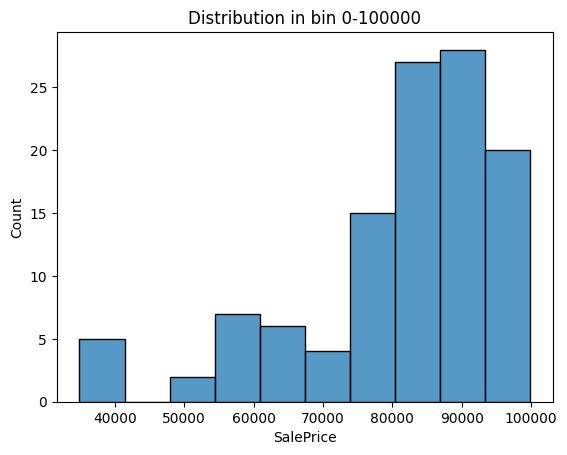

In [23]:
outlier_df, df_binned = bin_outliers(df, 'SalePrice', bin_size=100000, iqr_multiplier= 2)

print(outlier_df['bin_range'].value_counts())
target_bin = outlier_df['bin_range'].value_counts().idxmax()

df_bin = df_binned[df_binned['_bin'] == target_bin]

sns.histplot(df_bin['SalePrice'], bins= 10)
plt.title(f"Distribution in bin {target_bin}")
plt.show()


In [25]:
low_bin = "0-100000"
low_outliers = outlier_df[outlier_df['bin_range'] == low_bin]['index']
df.loc[low_outliers, [ 'SalePrice', 'Neighborhood', 'OverallQual']]

,SalePrice,Neighborhood,OverallQual
30,40000,IDOTRR,4
495,34900,IDOTRR,4
533,39300,BrkSide,1
705,55000,IDOTRR,4
710,52000,BrkSide,3
812,55993,IDOTRR,5
916,35311,IDOTRR,2
968,37900,OldTown,3
1325,55000,IDOTRR,4
1337,52500,OldTown,4


I say lets keep them as it seems legit sales to me and its only 10 for this data bins size and
I do tried some others methods to find legit outliers like KNN classification using grouping and all(didn't shown them as they unnecessary filling the space). so no issue on here by me. but there is one consideration you see i mentioned earlier<br>  
In real State buiseness sales ending with non-zero numbers are very rare as both buyer and sealer prefer clear value. we will not round the sales yet as it can create the jumps but i will submit with and without rounding them to check which one doing a better job.

In [27]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


#### Now we done with Outliers or unrealistic value issue. Lets work with the Feature enginerring.

In [28]:
X = df.drop(['SalePrice'], axis = 1).reset_index(drop=True)
target = pd.DataFrame(df['SalePrice']).reset_index(drop = True)

In [29]:
print(X.shape,target.shape,X_kaggle_df.shape)

(1460, 78) (1460, 1) (1459, 78)


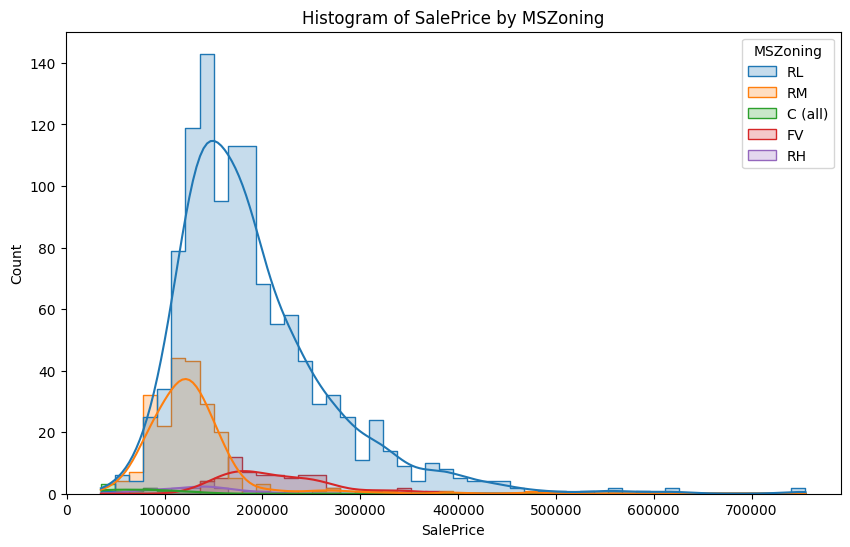

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='SalePrice', hue='MSZoning', bins=50, kde=True, element="step")
plt.title('Histogram of SalePrice by MSZoning')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

In [31]:
target = target.apply(np.log1p) # Right Skewed 

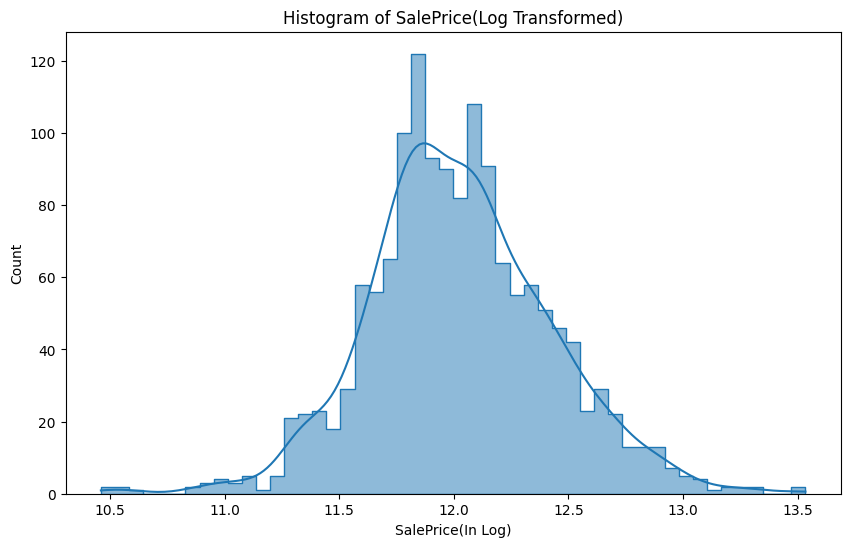

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot( x= target['SalePrice'], bins=50, kde=True, element="step")
plt.title('Histogram of SalePrice(Log Transformed)')
plt.xlabel('SalePrice(In Log)')
plt.ylabel('Count')
plt.show()

In [33]:
X.shape

(1460, 78)

In [34]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,NaN,0,12,2008,WD,Normal


Let's see how scatterplot looks like with the target variable

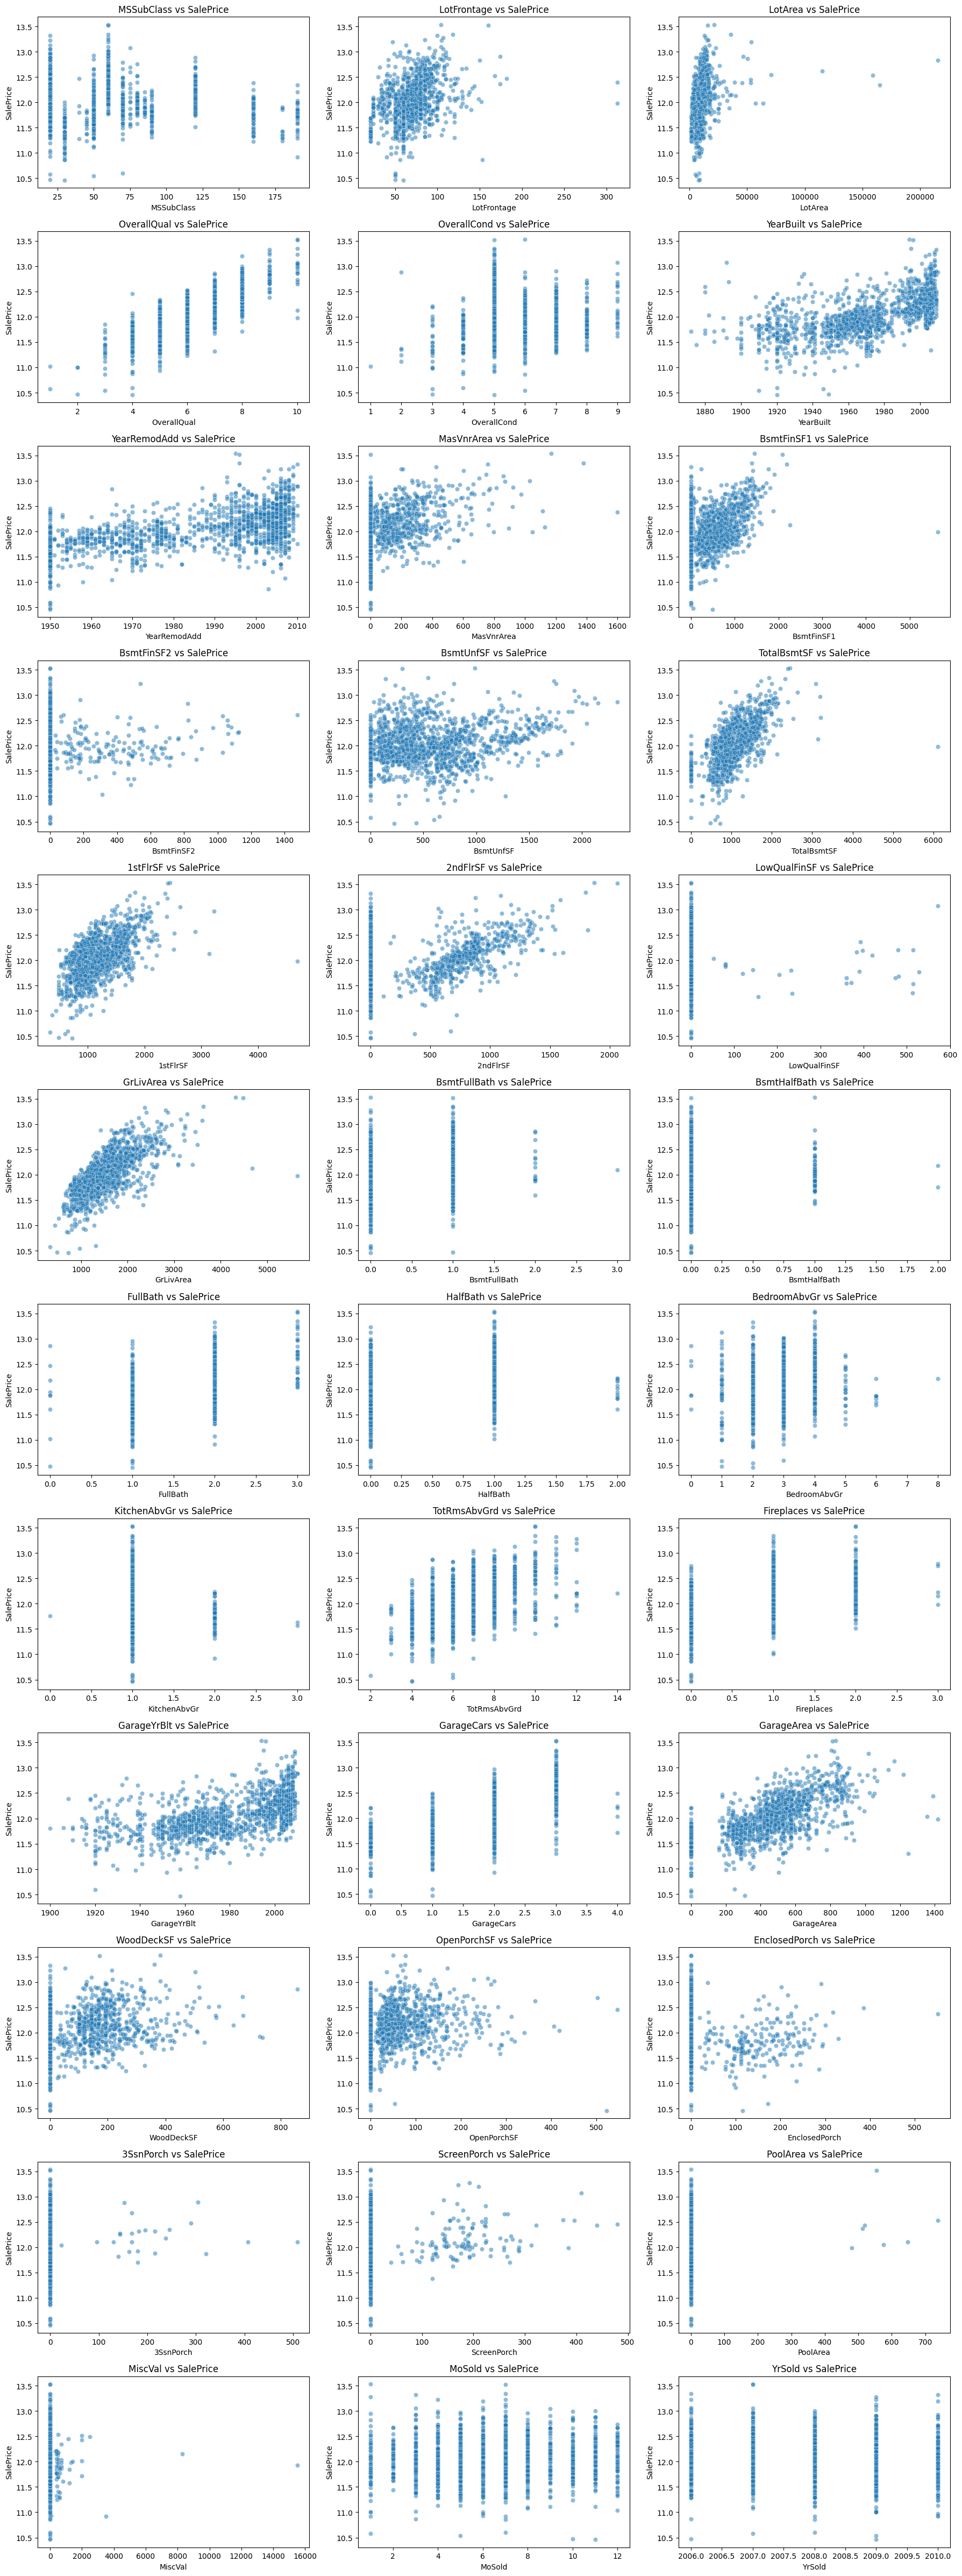

In [35]:
numeric_cols = X.select_dtypes(include='number').columns
target_col = target.squeeze() 
target_name = target_col.name if target_col.name else "Target"

n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=X[col], y=target_col, ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{col} vs {target_name}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_name)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [36]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


Seems like a lot of numerical columns behaves like a catagorical type and some has discreate catagory.So, lets deal with them now.<br>
<b>But first split the set</b> to avoid Data Leakage.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

In [38]:
print(X_train.shape,X_test.shape, X_kaggle_df.shape, y_train.shape,y_test.shape)

(1168, 78) (292, 78) (1459, 78) (1168, 1) (292, 1)


In [39]:
X_train = X_train.reset_index(drop = True) 
X_kaggle_df = X_kaggle_df.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [40]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [41]:
y_train.head()

,SalePrice
0,11.884496
1,12.089544
2,11.350418
3,12.072547
4,11.751950


In [42]:
y_test.head()

,SalePrice
0,11.947956
1,12.691584
2,11.652696
3,11.976666
4,12.661917


#### Mismatched Data type handling and null value handling

Data Filled for Null value will be the most common for that feature.

In [44]:
X_train['MSSubClass'] = X_train['MSSubClass'].apply(str)
X_train['YrSold'] = X_train['YrSold'].astype(str)
X_train['MoSold'] = X_train['MoSold'].astype(str)

X_train['Functional'] = X_train['Functional'].fillna('Typ')
X_train['Electrical'] = X_train['Electrical'].fillna("SBrkr")
X_train['KitchenQual'] = X_train['KitchenQual'].fillna("TA")
X_train['Exterior1st'] = X_train['Exterior1st'].fillna(X_train['Exterior1st'].mode()[0])
X_train['Exterior2nd'] = X_train['Exterior2nd'].fillna(X_train['Exterior2nd'].mode()[0])
X_train['SaleType'] = X_train['SaleType'].fillna(X_train['SaleType'].mode()[0])



In [45]:
X_test['MSSubClass'] = X_test['MSSubClass'].apply(str)
X_test['YrSold'] = X_test['YrSold'].astype(str)
X_test['MoSold'] = X_test['MoSold'].astype(str)

X_test['Functional'] = X_test['Functional'].fillna('Typ')
X_test['Electrical'] = X_test['Electrical'].fillna("SBrkr")
X_test['KitchenQual'] = X_test['KitchenQual'].fillna("TA")
X_test['Exterior1st'] = X_test['Exterior1st'].fillna(X_test['Exterior1st'].mode()[0])
X_test['Exterior2nd'] = X_test['Exterior2nd'].fillna(X_test['Exterior2nd'].mode()[0])
X_test['SaleType'] = X_test['SaleType'].fillna(X_test['SaleType'].mode()[0])



Mode of traning set is used above to avoid Data Leakage.

In [46]:
X_kaggle_df['MSSubClass'] = X_kaggle_df['MSSubClass'].apply(str)
X_kaggle_df['YrSold'] = X_kaggle_df['YrSold'].astype(str)
X_kaggle_df['MoSold'] = X_kaggle_df['MoSold'].astype(str)

X_kaggle_df['Functional'] = X_kaggle_df['Functional'].fillna('Typ')
X_kaggle_df['Electrical'] = X_kaggle_df['Electrical'].fillna("SBrkr")
X_kaggle_df['KitchenQual'] = X_kaggle_df['KitchenQual'].fillna("TA")
X_kaggle_df['Exterior1st'] = X_kaggle_df['Exterior1st'].fillna(X_train['Exterior1st'].mode()[0])
X_kaggle_df['Exterior2nd'] = X_kaggle_df['Exterior2nd'].fillna(X_train['Exterior2nd'].mode()[0])
X_kaggle_df['SaleType'] = X_kaggle_df['SaleType'].fillna(X_train['SaleType'].mode()[0])



They can be zero and null as houses can have them or maybe not.

In [47]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X_train[col] = X_train[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    X_train[col] = X_train[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X_train[col] = X_train[col].fillna('None')

X_train['MSZoning'] = X_train.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in X_train.columns:
    if X_train[i].dtype == object:
        objects.append(i)

X_train.update(X_train[objects].fillna('None'))

X_train['LotFrontage'] = X_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [48]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X_test[col] = X_test[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    X_test[col] = X_test[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X_test[col] = X_test[col].fillna('None')


mszoning_modes = X_train.groupby('MSSubClass')['MSZoning'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)


X_test['MSZoning'] = X_test.apply(
    lambda row: mszoning_modes[row['MSSubClass']] if pd.isna(row['MSZoning']) else row['MSZoning'],
    axis=1
)


objects = []
for i in X_test.columns:
    if X_test[i].dtype == object:
        objects.append(i)

X_test.update(X_test[objects].fillna('None'))


lotfrontage_medians = X_train.groupby('Neighborhood')['LotFrontage'].median()

X_test['LotFrontage'] = X_test.apply(
    lambda row: lotfrontage_medians[row['Neighborhood']] if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)



In [49]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X_kaggle_df[col] = X_kaggle_df[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    X_kaggle_df[col] = X_kaggle_df[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X_kaggle_df[col] = X_kaggle_df[col].fillna('None')


mszoning_modes = X_train.groupby('MSSubClass')['MSZoning'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)


X_kaggle_df['MSZoning'] = X_kaggle_df.apply(
    lambda row: mszoning_modes[row['MSSubClass']] if pd.isna(row['MSZoning']) else row['MSZoning'],
    axis=1
)


objects = []
for i in X_kaggle_df.columns:
    if X_kaggle_df[i].dtype == object:
        objects.append(i)

X_kaggle_df.update(X_kaggle_df[objects].fillna('None'))


lotfrontage_medians = X_train.groupby('Neighborhood')['LotFrontage'].median()

X_kaggle_df['LotFrontage'] = X_kaggle_df.apply(
    lambda row: lotfrontage_medians[row['Neighborhood']] if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)



In [50]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Know only int64 and flot64 are there but anyway no harm in checking again 
numerics = []
for i in X_train.columns:
    if X_train[i].dtype in numeric_dtypes:
        numerics.append(i)
X_train.update(X_train[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in X_train.columns:
    if X_train[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [51]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in X_test.columns:
    if X_test[i].dtype in numeric_dtypes:
        numerics.append(i)
X_test.update(X_test[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in X_test.columns:
    if X_test[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [52]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in X_kaggle_df.columns:
    if X_kaggle_df[i].dtype in numeric_dtypes:
        numerics.append(i)
X_kaggle_df.update(X_kaggle_df[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in X_kaggle_df.columns:
    if X_kaggle_df[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [53]:
X_train.select_dtypes('number')[X_train.select_dtypes('number').columns].isnull().sum()

LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
dtype: int64

In [54]:
X_train = X_train.reset_index(drop = True) 
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
X_kaggle_df = X_kaggle_df.reset_index( drop = True)

In [55]:
X_train[X_train.columns[X_train.isnull().any()]].isnull().sum() 

Series([], dtype: float64)

In [56]:
X_test[X_test.columns[X_test.isnull().any()]].isnull().sum() 

Series([], dtype: float64)

In [57]:
X_kaggle_df[X_kaggle_df.columns[X_kaggle_df.isnull().any()]].isnull().sum() 

Series([], dtype: float64)

### Let's make some new columns 

I will later use Simple Imputer in pipeline to handle null which needed to fill with median.

In [58]:
X_train['LotAreaRatio'] = np.where( X_train['LotArea'].isna() | X_train['LotFrontage'].isna() | (X_train['LotFrontage'] == 0),
                                    np.nan, (X_train['LotArea']/X_train['LotFrontage']))

X_test['LotAreaRatio'] = np.where( X_test['LotArea'].isna() | X_test['LotFrontage'].isna() | (X_test['LotFrontage']== 0),
                                    np.nan, (X_test['LotArea']/X_test['LotFrontage']))

In [59]:
X_kaggle_df['LotAreaRatio'] = np.where( X_kaggle_df['LotArea'].isna() | X_kaggle_df['LotFrontage'].isna() | (X_kaggle_df['LotFrontage']== 0),
                                    np.nan, (X_kaggle_df['LotArea']/ X_kaggle_df['LotFrontage']))

In [60]:
X_train['HouseAge'] = X_train['YrSold'].astype(int) - X_train['YearBuilt']
X_train['SinceRemodel'] = X_train['YrSold'].astype(int) - X_train['YearRemodAdd']
X_train['Is_Remodeled'] = np.where(
    X_train['YearBuilt'].isna() | X_train['YearRemodAdd'].isna(),
    np.nan,
    (X_train['YearBuilt'] != X_train['YearRemodAdd']).astype(int)
)

X_test['HouseAge'] = X_test['YrSold'].astype(int) - X_test['YearBuilt']
X_test['SinceRemodel'] = X_test['YrSold'].astype(int) - X_test['YearRemodAdd']
X_test['Is_Remodeled'] = np.where(
    X_test['YearBuilt'].isna() | X_test['YearRemodAdd'].isna(),
    np.nan,
    (X_test['YearBuilt'] != X_test['YearRemodAdd']).astype(int)
)
X_kaggle_df['HouseAge'] = X_kaggle_df['YrSold'].astype(int) - X_kaggle_df['YearBuilt']
X_kaggle_df['SinceRemodel'] = X_kaggle_df['YrSold'].astype(int) - X_kaggle_df['YearRemodAdd']
X_kaggle_df['Is_Remodeled'] = np.where(
    X_kaggle_df['YearBuilt'].isna() | X_kaggle_df['YearRemodAdd'].isna(),
    np.nan,
    (X_kaggle_df['YearBuilt'] != X_kaggle_df['YearRemodAdd']).astype(int)
)

In [61]:
X_train['TotalSF'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']
X_test['TotalSF'] = X_test['TotalBsmtSF'] + X_test['1stFlrSF'] + X_test['2ndFlrSF']
X_kaggle_df['TotalSF'] = X_kaggle_df['TotalBsmtSF'] + X_kaggle_df['1stFlrSF'] + X_kaggle_df['2ndFlrSF']

In [62]:
X_train['GarageAge'] = np.where( X_train['YrSold'].astype(int).isna() | X_train['GarageYrBlt'].isna() ,
                                    np.nan,(X_train['YrSold'].astype(int) - X_train['GarageYrBlt']))

X_test['GarageAge'] = np.where( X_test['YrSold'].astype(int).isna() | X_test['GarageYrBlt'].isna() ,
                                    np.nan,(X_test['YrSold'].astype(int) - X_test['GarageYrBlt']))

X_train['HasGarage'] = np.where(
    X_train['GarageArea'].isna(), 
    np.nan, 
    (X_train['GarageArea'] > 0).astype(int)
)
X_test['HasGarage'] = np.where(
    X_test['GarageArea'].isna(), 
    np.nan, 
    (X_test['GarageArea'] > 0).astype(int)
)

X_kaggle_df['GarageAge'] = np.where( X_kaggle_df['YrSold'].astype(int).isna() | X_kaggle_df['GarageYrBlt'].isna() ,
                                    np.nan,(X_kaggle_df['YrSold'].astype(int) - X_kaggle_df['GarageYrBlt']))
X_kaggle_df['HasGarage'] = np.where(
    X_kaggle_df['GarageArea'].isna(), 
    np.nan, 
    (X_kaggle_df['GarageArea'] > 0).astype(int)
)

In [63]:
X_train['Total_Bathrooms'] = (X_train['FullBath'] + (0.5 * X_train['HalfBath']) +
                               X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']))

X_train['Total_porch_sf'] = (X_train['OpenPorchSF'] + X_train['3SsnPorch'] +
                              X_train['EnclosedPorch'] + X_train['ScreenPorch'] +
                              X_train['WoodDeckSF'])

In [64]:
X_test['Total_Bathrooms'] = (X_test['FullBath'] + (0.5 * X_test['HalfBath']) +
                               X_test['BsmtFullBath'] + (0.5 * X_test['BsmtHalfBath']))

X_test['Total_porch_sf'] = (X_test['OpenPorchSF'] + X_test['3SsnPorch'] +
                              X_test['EnclosedPorch'] + X_test['ScreenPorch'] +
                              X_test['WoodDeckSF'])

In [65]:
X_kaggle_df['Total_Bathrooms'] = (X_kaggle_df['FullBath'] + (0.5 * X_kaggle_df['HalfBath']) +
                               X_kaggle_df['BsmtFullBath'] + (0.5 * X_kaggle_df['BsmtHalfBath']))

X_kaggle_df['Total_porch_sf'] = (X_kaggle_df['OpenPorchSF'] + X_kaggle_df['3SsnPorch'] +
                              X_kaggle_df['EnclosedPorch'] + X_kaggle_df['ScreenPorch'] +
                              X_kaggle_df['WoodDeckSF'])

In [66]:
X_train = X_train.reset_index(drop = True) 
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
X_kaggle_df = X_kaggle_df.reset_index( drop = True)

In [67]:
print(X_train.shape, X_test.shape,X_kaggle_df.shape, y_train.shape,y_test.shape)

(1168, 87) (292, 87) (1459, 87) (1168, 1) (292, 1)


## Lets work with the Correlation

Well we are with feature enginerring so for now lets combined set to make our work easy.

In [68]:
len_split = len(X_train)
df_new = pd.concat([X_train, X_test], axis= 0).reset_index(drop = True)
target = pd.concat([y_train, y_test], axis= 0).reset_index(drop = True)

In [69]:
print(df_new.shape,target.shape)

(1460, 87) (1460, 1)


In [70]:
numeric_X_train = df_new.select_dtypes(include='number')
cat_X_train = df_new.select_dtypes(include='object')
str_X_train = df_new.select_dtypes(include='string')

In [71]:
print(numeric_X_train.shape, cat_X_train.shape, str_X_train.shape)

(1460, 42) (1460, 45) (1460, 0)


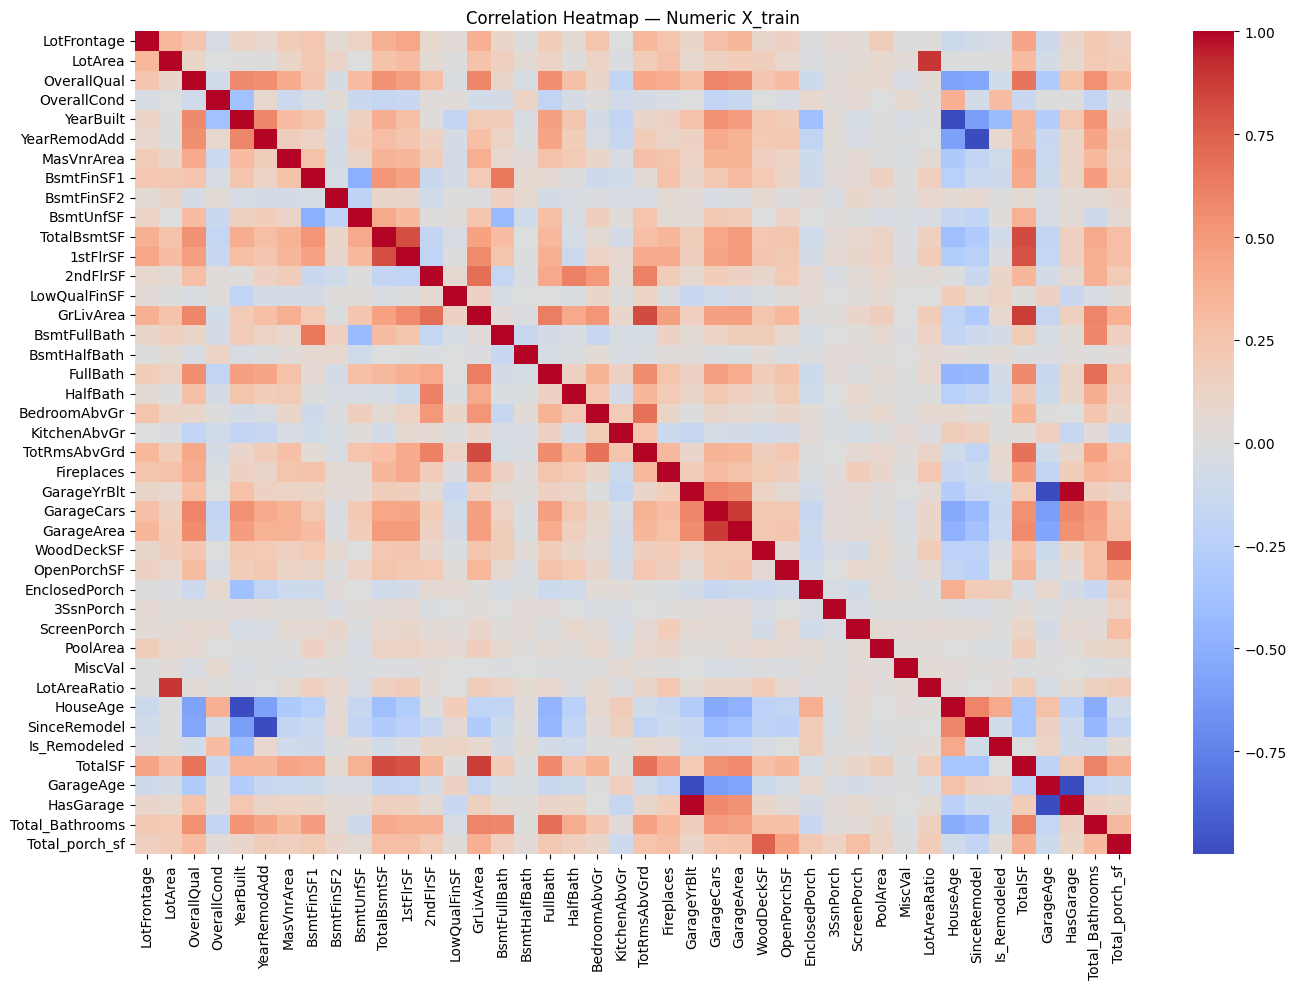

In [72]:
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_X_train.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap — Numeric X_train")
plt.tight_layout()
plt.show()

In [73]:
# Get correlation matrix
corr_matrix = numeric_X_train.corr()

# Filter pairs with correlation > 0.8 (excluding self-correlation)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

# Display
print("Highly correlated numeric feature pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} ⟷ {pair[1]} = {pair[2]:.2f}")


Highly correlated numeric feature pairs (|r| > 0.8):
1stFlrSF ⟷ TotalBsmtSF = 0.82
TotRmsAbvGrd ⟷ GrLivArea = 0.83
GarageArea ⟷ GarageCars = 0.88
LotAreaRatio ⟷ LotArea = 0.89
HouseAge ⟷ YearBuilt = -1.00
SinceRemodel ⟷ YearRemodAdd = -1.00
TotalSF ⟷ TotalBsmtSF = 0.83
TotalSF ⟷ 1stFlrSF = 0.80
TotalSF ⟷ GrLivArea = 0.87
GarageAge ⟷ GarageYrBlt = -1.00
HasGarage ⟷ GarageYrBlt = 1.00
HasGarage ⟷ GarageAge = -1.00


In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = numeric_X_train.dropna()
# Remove perfectly correlated or constant columns to avoid infinite VIFs
X = X.loc[:, X.std() > 0]  
X_const = add_constant(X)

# Compute VIF
vif = pd.Series(
    [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
    index=X_const.columns
)

# Display sorted VIF values
print(vif.sort_values(ascending=False))


BsmtFinSF2                  inf
YearBuilt                   inf
YearRemodAdd                inf
BsmtUnfSF                   inf
BsmtFinSF1                  inf
BsmtFullBath                inf
GrLivArea                   inf
LowQualFinSF                inf
2ndFlrSF                    inf
1stFlrSF                    inf
TotalBsmtSF                 inf
Total_porch_sf              inf
Total_Bathrooms             inf
GarageAge                   inf
HouseAge                    inf
SinceRemodel                inf
EnclosedPorch               inf
BsmtHalfBath                inf
FullBath                    inf
HalfBath                    inf
GarageYrBlt                 inf
TotalSF                     inf
ScreenPorch                 inf
3SsnPorch                   inf
WoodDeckSF                  inf
OpenPorchSF                 inf
const              2.379582e+06
HasGarage          1.431177e+03
LotArea            1.083328e+01
LotAreaRatio       9.874773e+00
GarageCars         6.072177e+00
GarageAr

<b>VIF tells infinity </b>for some columns its occurs when column are linear combination of others and they are problem for non-tree based model as it can give error or poorly performance or maybe can act as a source of data leakage.
For tree based model it does not affect as much as the non tree models but it is sensitive to log transformations. So we will deal with them

### Can check below to verify VIF 

In [75]:
df_new['TotalBsmtSF'] == df_new['BsmtFinSF1'] + df_new['BsmtFinSF2'] + df_new['BsmtUnfSF']

0       True
1       True
2       True
3       True
4       True
        ... 
1455    True
1456    True
1457    True
1458    True
1459    True
Length: 1460, dtype: bool

In [76]:
df_new.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [77]:
drop_cols = [
    'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
    'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea',
    'LotArea', 'FullBath', 'HalfBath',
    'BsmtFullBath', 'BsmtHalfBath',
    'GrLivArea', '1stFlrSF', '2ndFlrSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'Total_porch_sf',  # keeping the decomposed ones 
    'HasGarage', 'GarageAge', 'SinceRemodel'
]

df_new = df_new.drop(drop_cols, axis = 1)
X_kaggle_df = X_kaggle_df.drop(drop_cols, axis = 1)

In [78]:
X = df_new.select_dtypes('number').dropna()

X = X.loc[:, X.std() > 0]  
X_const = add_constant(X)

vif = pd.Series(
    [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
    index=X_const.columns
)

print(vif.sort_values(ascending=False))


const              116.973744
TotalSF              9.643097
BsmtUnfSF            5.843687
BsmtFinSF1           5.559224
OverallQual          3.064329
HouseAge             2.983190
Total_Bathrooms      2.901702
GarageCars           1.932117
BedroomAbvGr         1.717648
BsmtFinSF2           1.552691
Fireplaces           1.456161
Is_Remodeled         1.364030
LotFrontage          1.355463
MasVnrArea           1.353929
OverallCond          1.321609
KitchenAbvGr         1.221188
WoodDeckSF           1.174690
LotAreaRatio         1.143420
PoolArea             1.080614
LowQualFinSF         1.069915
MiscVal              1.016337
dtype: float64


In [79]:
# Get correlation matrix
corr_matrix = df_new.select_dtypes('number').corr()

# Filter pairs with correlation > 0.8 (excluding self-correlation)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))

# Display
print("Highly correlated numeric feature pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} ⟷ {pair[1]} = {pair[2]:.2f}")


Highly correlated numeric feature pairs (|r| > 0.8):


## Now lets check the scale or skewness of numerical variables

In [80]:
skew_dict = {}
zero_or_less_flag = {}

for col in df_new.select_dtypes('number').columns:
    skew_dict[col] = df_new[col].skew()
    zero_or_less_flag[col] = (df_new[col] <= 0).any()

# Create DataFrame
skew_df = pd.DataFrame.from_dict(skew_dict, orient='index', columns=['Skewness'])

# Add zero-or-less flag
skew_df['Has_Zero_or_Negative'] = pd.Series(zero_or_less_flag)

# Sort by skewness descending
skew_df = skew_df.sort_values(by='Skewness', ascending=False)

# Filter: Only show numeric columns with skewness < 1
filtered_skew_df = skew_df[skew_df['Skewness'] < 1]

# Display
print(filtered_skew_df)


                 Skewness  Has_Zero_or_Negative
BsmtUnfSF        0.920268                  True
OverallCond      0.693067                 False
Fireplaces       0.649565                  True
HouseAge         0.609030                  True
Total_Bathrooms  0.264676                 False
OverallQual      0.216944                 False
BedroomAbvGr     0.211790                  True
Is_Remodeled     0.093348                  True
GarageCars      -0.342549                  True


Seems many of them needs to be transformed will use log transformation to normilize them but we will leave those which contain 0 or less value (Log is not defined for 0 and negative).

In [81]:
# Transforming only those which have false for 0 or negative value
log_transform_to = skew_df[
    (skew_df['Skewness'] > 0.9) & (skew_df['Has_Zero_or_Negative'] == False)
].index.tolist()

# Apply log1p transform to avoid issues with very small values
df_new[log_transform_to] = df_new[log_transform_to].apply(np.log1p)
X_kaggle_df[log_transform_to] = X_kaggle_df[log_transform_to].apply(np.log1p)
print(f"Log transform applied to: {log_transform_to}")

Log transform applied to: ['LotAreaRatio', 'LotFrontage', 'TotalSF']


In [82]:
import math

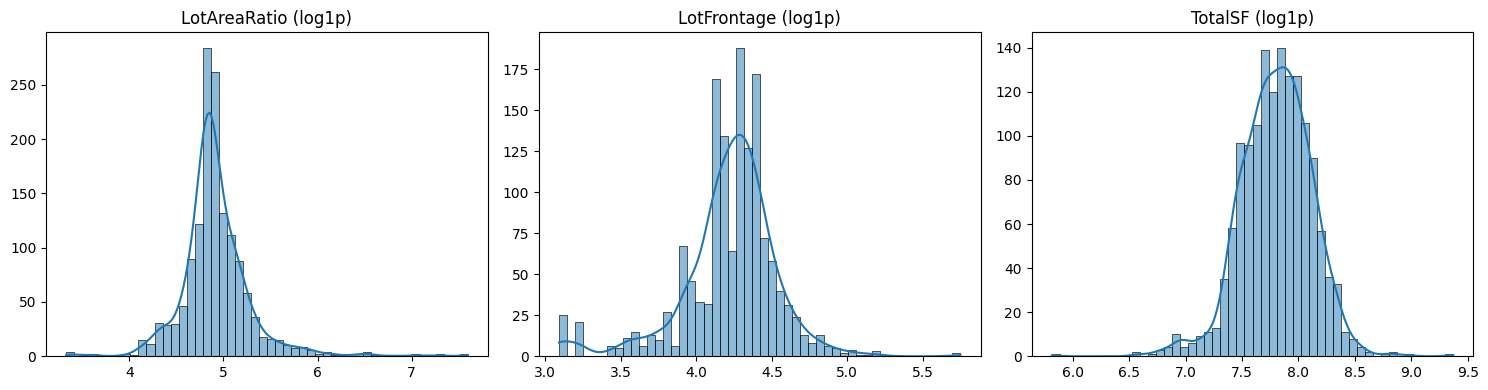

In [83]:
n_cols = 3
n_rows = math.ceil(len(log_transform_to) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Plot each column in a subplot
for i, col in enumerate(log_transform_to, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_new[col], kde=True, bins=50)
    plt.title(f"{col} (log1p)")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

Let's see how well we do on model and compare different models score with combined score.

Adding one more column because running the model a few times I observed its not performing good on high SalePrice.

It will help the model even if it is small.

In [84]:
df_new['LuxuryHome'] = (
    (df['GrLivArea'] > 3500) |             # Large living area
    (df['OverallQual'] >= 9) |            # High overall quality
    (df['GarageCars'] >= 3) |             # Large garage
    (df['TotalBsmtSF'] > 1500) |          # Big basement
    (df['PoolArea'] > 0) |                # Pool present
    (df['LotArea'] > 15000)               # Large lot
).astype(int)


In [85]:
X_kaggle_df['LuxuryHome'] = (
    (df['GrLivArea'] > 3500) |            
    (df['OverallQual'] >= 9) |            
    (df['GarageCars'] >= 3) |             
    (df['TotalBsmtSF'] > 1500) |         
    (df['PoolArea'] > 0) |                
    (df['LotArea'] > 15000)               
).astype(int)


In [86]:
print(df_new.shape, X_kaggle_df.shape)

(1460, 66) (1459, 66)


# Model Preparation

Some Useful plot we are going to use multiple times.

In [87]:
def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted SalePrice"):
    """
    Plots a scatter plot of actual vs predicted values with a y=x reference line.
    
    Parameters:
        y_true (array-like): Ground truth target values.
        y_pred (array-like): Predicted target values.
        title (str): Title of the plot.
    """
    # Flatten inputs
    y_true_flat = np.ravel(y_true)
    y_pred_flat = np.ravel(y_pred)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_flat, y=y_pred_flat, alpha=0.6, color='blue', label="Predictions")

    # Reference line: y = x
    max_val = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([0, max_val], [0, max_val], '--r', label='Ideal Fit (y = x)')

    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [88]:
def plot_residuals(y_true, y_pred, title="Residual Plot"):
    """
    Plots residuals (actual - predicted) vs predicted values.
    
    Parameters:
        y_true (array-like): Ground truth values.
        y_pred (array-like): Predicted values.
        title (str): Plot title.
    """
    # Flatten arrays if needed
    y_true_flat = np.ravel(y_true)
    y_pred_flat = np.ravel(y_pred)

    # Calculate residuals
    residuals = y_true_flat - y_pred_flat

    # Create DataFrame
    residual_df = pd.DataFrame({
        "Predicted Values": y_pred_flat,
        "Residuals": residuals
    })

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="Predicted Values", y="Residuals", data=residual_df, alpha=0.6)
    sns.regplot(
        x="Predicted Values",
        y="Residuals",
        data=residual_df,
        scatter=False,
        lowess=True,
        color="red",
        line_kws={"linestyle": "--"}
    )

    plt.axhline(0, color='black', linestyle='dotted')
    plt.title(title)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [89]:
def plot_error_by_price_range(y_true, y_pred, bins=None, labels=None, title="Mean Absolute Error by Price Range"):
    """
    Plots mean absolute error grouped by price range bins.

    Parameters:
    - y_true: array-like, original target values (e.g., y_test_org)
    - y_pred: array-like, predicted values (e.g., np.expm1(model.predict(...)))
    - bins: list of bin edges (optional)
    - labels: list of bin labels (optional)
    - title: str, plot title (optional)

    Returns:
    - summary: DataFrame with error stats per price bin
    """

    # Default bins if not provided
    if bins is None:
        bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 1e6]
    if labels is None:
        labels = ['0-100k', '100k-200k', '200k-300k', '300k-400k',
                  '400k-500k', '500k-600k', '600k-1M']

    # Flatten predictions and targets
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Compute errors
    errors = np.abs(y_pred - y_true)

    # Bin the prices
    price_bins = pd.cut(y_true, bins=bins, labels=labels, right=False)

    # Build error DataFrame
    error_df = pd.DataFrame({
        'Price': y_true,
        'Error': errors,
        'Bin': price_bins
    })

    # Aggregate statistics
    summary = error_df.groupby('Bin').agg(
        Count=('Error', 'count'),
        Mean_Error=('Error', 'mean'),
        Total_Error=('Error', 'sum')
    )
    summary['%_Total_Error'] = 100 * summary['Total_Error'] / summary['Total_Error'].sum()

    # Plot
    plt.figure(figsize=(10, 5))
    summary['Mean_Error'].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Price Range")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return summary


Splitting Back

In [90]:
X_train = df_new.iloc[:len_split].reset_index(drop=True)
X_test = df_new.iloc[len_split:].reset_index(drop=True)
y_train = target.iloc[:len_split].reset_index(drop=True)
y_test = target.iloc[len_split:].reset_index(drop=True)

In [91]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape, X_kaggle_df.shape)

(1168, 66) (292, 66) (1168, 1) (292, 1) (1459, 66)


In [92]:
# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose= False)
categorical_transformer = Pipeline([
    ('target_encoder', TargetEncoder(handle_missing='value', handle_unknown='value')),
], verbose= False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer,X_train.select_dtypes(include = 'number').columns),
    ('cat', categorical_transformer, X_train.select_dtypes(include = ['object','category']).columns)
], verbose= False)

In [119]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def optimize_xgb(X, y, n_trials=100, use_gpu=True, cv_splits=5, seed=42, n_jobs=6):
    def objective(trial):
        params = {
            'n_estimators':      trial.suggest_int('n_estimators', 500, 5000),
            'max_depth':         trial.suggest_int('max_depth', 2, 10),
            'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma':             trial.suggest_float('gamma', 0.0, 5.0),
            'min_child_weight':  trial.suggest_int('min_child_weight', 0, 10),
            'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda':        trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            # fixed
            'objective':         'reg:squarederror',
            'random_state':      seed,
            'verbosity':         0,
            'n_jobs':            n_jobs,
            'scale_pos_weight':  1
        }

        if use_gpu:
            params['tree_method']   = 'gpu_hist'
            params['predictor']     = 'gpu_predictor'
        
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(**params))
        ])
        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)
        scores = cross_val_score(
            model, X, y,
            scoring= 'neg_root_mean_squared_error',
            cv=cv,
            n_jobs=1 
        )
        return -scores.mean()

    # === run Optuna ===
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("✅ Best Parameters:", study.best_params)
    print("📉 Best CV RMSE  :", study.best_value)

    # === retrain final model on full data ===
    best_params = study.best_params.copy()
    # re-add fixed params
    best_params.update({
        'objective':        'reg:squarederror',
        'random_state':     seed,
        'verbosity':        0,
        'n_jobs':           n_jobs,
        'scale_pos_weight': 1
    })
    if use_gpu:
        best_params['tree_method']   = 'gpu_hist'
        best_params['predictor']     = 'gpu_predictor'

    final_model = Pipeline([
                               ('preprocessor', preprocessor),
                               ('regressor',XGBRegressor(**best_params))
                           ])
    final_model.fit(X, y)

    return study, final_model


In [94]:
y_train = y_train.squeeze()

In [95]:
y_test = y_test.squeeze()

In [99]:
y_train_org = np.expm1(y_train)

In [100]:
y_test_org = np.expm1(y_test)

In [101]:
target = target.squeeze()

In [102]:
target_org = np.expm1(target)

In [103]:
def log_rmse(y_true, y_pred):
    y_pred_log = np.log1p(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred_log))

#### Xgboost on seed 42

In [104]:
study, xgb_model_seed42 = optimize_xgb(X_train, y_train, n_trials = 100, use_gpu=True, cv_splits=5, seed=42,n_jobs=6)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'n_estimators': 2531, 'max_depth': 3, 'learning_rate': 0.015137998558595536, 'subsample': 0.6106486839070331, 'colsample_bytree': 0.6693555984915334, 'gamma': 0.0038709311897990803, 'min_child_weight': 1, 'reg_alpha': 0.17964515790347424, 'reg_lambda': 0.0030733580818517684}
📉 Best CV RMSE  : 0.11942114742258277


In [105]:
y_pred_test_seed42 = np.expm1(xgb_model_seed42.predict(X_test))

In [106]:
y_pred_train_seed42 = np.expm1(xgb_model_seed42.predict(X_train)).astype(int)

In [108]:
print(" XGBoost Log RMSE on Test Set:", round(log_rmse(y_test, y_pred_test_seed42), 4))

 XGBoost Log RMSE on Test Set: 0.1343


In [109]:
print(" XGBoost Log RMSE on Train Set:", round(log_rmse(y_train, y_pred_train_seed42), 4))

 XGBoost Log RMSE on Train Set: 0.05


In [112]:
print("Percentage Decrement by: ", round(log_rmse(y_test, y_pred_test_seed42)/log_rmse(y_train, y_pred_train_seed42),4), "times")

Percentage Decrement by:  2.6889 times


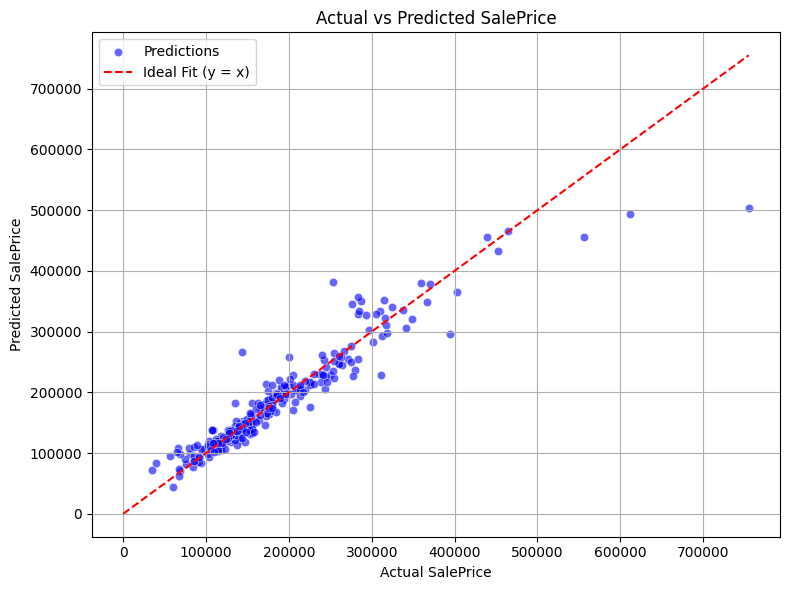

In [113]:
plot_actual_vs_pred(y_test_org,y_pred_test_seed42)

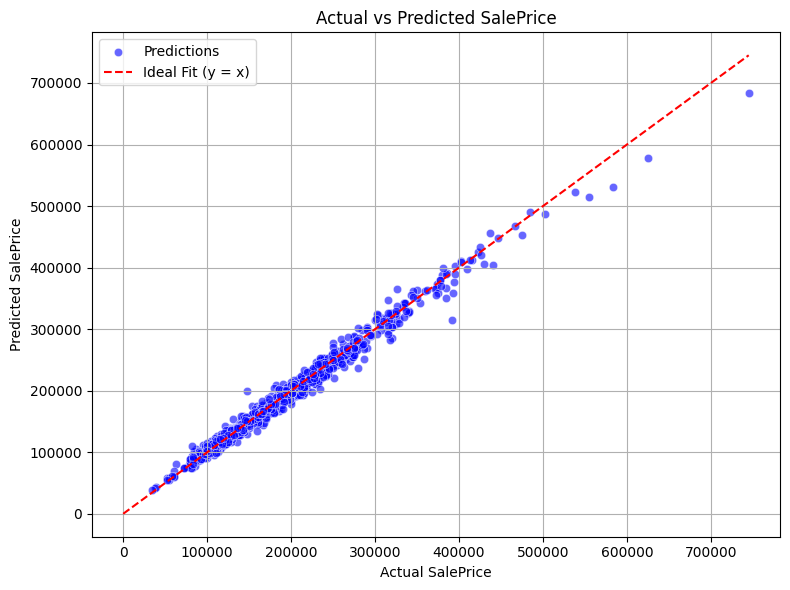

In [114]:
plot_actual_vs_pred(y_train_org,y_pred_train_seed42)

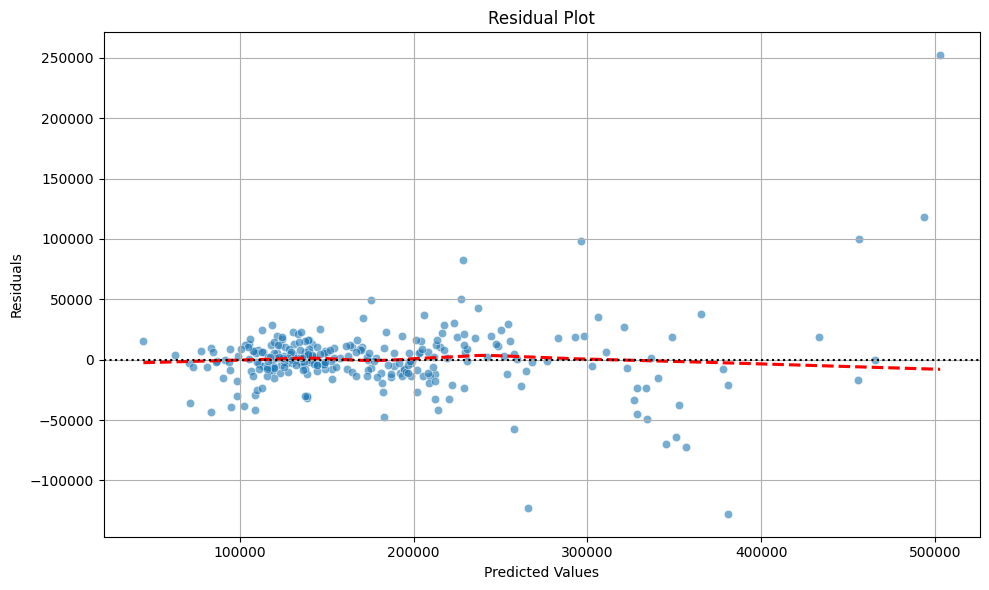

In [115]:
plot_residuals(y_test_org,y_pred_test_seed42)

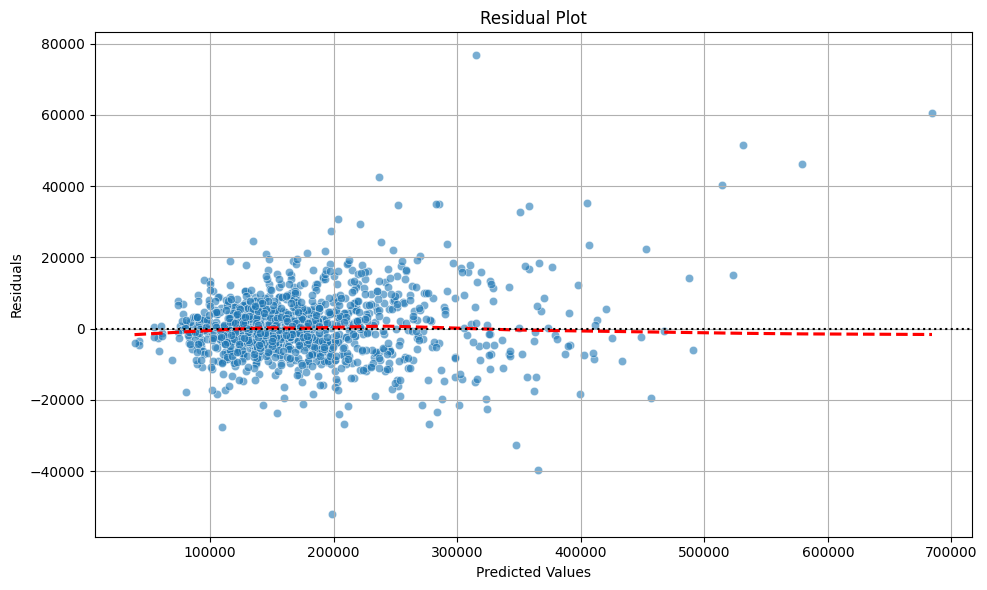

In [116]:
plot_residuals(y_train_org,y_pred_train_seed42)

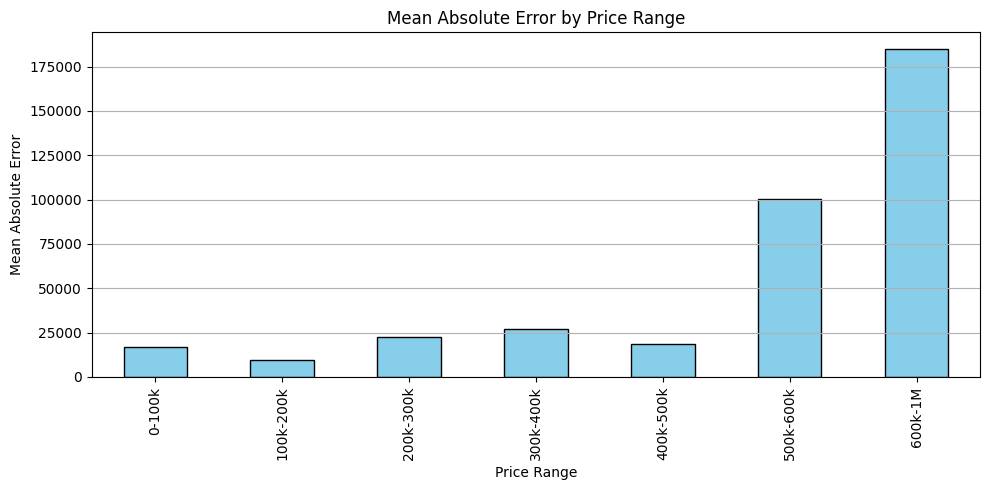

,Count,Mean_Error,Total_Error,%_Total_Error
Bin,,,,
0-100k,26,16626.358774,4.322853e+05,9.662725
100k-200k,184,9444.294582,1.737750e+06,38.843333
200k-300k,58,22368.107489,1.297350e+06,28.999224
300k-400k,17,27197.439338,4.623565e+05,10.334895
400k-500k,4,18400.007812,7.360003e+04,1.645156
500k-600k,1,100252.437500,1.002524e+05,2.240908
600k-1M,2,185073.281250,3.701466e+05,8.273759


In [118]:
plot_error_by_price_range(y_test_org , y_pred_test_seed42)

Tried Xgboost with seed 45, 20 and 27 as well deleted them as they are unnecessary filling the notebook. Best CV RSME was given by seed 42 and best performance on traning set by seed 27 with 0.018 something but didn't choose those as RSME on test set was high and not to mention CV RSME was higher then seed 42 as well. So, Gonna pick seed 42 for traning in whole dataset( This is not data leakage ) as we will use it to submit in the kaggle.

### Xgboost Traning on full dataset(will submit predict for kaggle from this).

In [120]:
study, xgb_model_final = optimize_xgb(df_new, target, n_trials = 100, use_gpu=True, cv_splits=5, seed=42,n_jobs=6)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'n_estimators': 2558, 'max_depth': 7, 'learning_rate': 0.03134290332472649, 'subsample': 0.7445924932983642, 'colsample_bytree': 0.5544380164378299, 'gamma': 0.0018909603957599575, 'min_child_weight': 6, 'reg_alpha': 0.06583676732951144, 'reg_lambda': 0.018869932430421878}
📉 Best CV RMSE  : 0.12343457602360382


In [121]:
y_pred_xgb_final = np.expm1(xgb_model_final.predict(X_kaggle_df))

### SVR Traning on full dataset(will submit predict for kaggle from this)

In [128]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def optimize_svr(X, y, n_trials=100, cv_splits=5, seed=42, n_jobs= 6):
    """
    Optimize an SVR model using Optuna and return the study and the fitted model.

    Parameters:
    - X: features (DataFrame or array)
    - y: target array-like
    - n_trials: number of Optuna trials
    - cv_splits: number of CV folds
    - seed: random seed for reproducibility
    - n_jobs: parallel jobs for cross-validation (None means 1)

    Returns:
    - study: Optuna Study object
    - final_model: Fitted SVR model with best params
    """
    def objective(trial):
        # Suggest hyperparameters
        kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
        params = {
            'kernel': kernel,
            'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'epsilon': trial.suggest_float('epsilon', 1e-4, 1.0, log=True),
        }
        # Kernel-specific parameters
        if kernel in ['rbf', 'poly']:
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree',1, 2)
            params['coef0'] = trial.suggest_float('coef0', 0.0, 1.0)

        # Initialize model
        model = Pipeline([('preprocessor', preprocessor),
                          ('regressor',SVR(**params))
                         ])
        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)
        scores = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs = n_jobs
        )
        # Return mean RMSE
        return -scores.mean()

    # Create and run Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs= 1)

    # Print best results
    print("✅ Best Parameters:", study.best_params)
    print("📉 Best CV RMSE :", study.best_value)

    # Retrain final SVR on full dataset
    best_params = study.best_params.copy()
    final_model = Pipeline([('preprocessor', preprocessor),
                          ('regressor',SVR(**best_params))
                         ])
    final_model.fit(X, y)

    return study, final_model


In [129]:
study_svr, svr_model_final = optimize_svr(df_new, target, n_trials = 100,cv_splits=5, seed=42,n_jobs = 6)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'kernel': 'rbf', 'C': 6.167045808628002, 'epsilon': 0.0005231021138168825, 'gamma': 0.0023026597624132028}
📉 Best CV RMSE : 0.12472542128977038


In [130]:
y_svr_pred_final = np.expm1(svr_model_final.predict(X_kaggle_df))

### LassoLar AIC Traning on full dataset(will submit predict for kaggle from this)

In [135]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def aic_score(y_true, y_pred, n_params):
    """
    Compute AIC score: AIC = n * log(RSS/n) + 2k
    where k is the number of parameters used
    """
    n = len(y_true)
    resid = y_true - y_pred
    rss = np.sum(resid**2)
    aic = n * np.log(rss / n) + 2 * n_params
    return aic

def optimize_lassolars(X, y, n_trials=50, seed=42):
    def objective(trial):
        alpha = trial.suggest_float('alpha', 1e-6, 10.0, log=True)

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LassoLars(alpha=alpha))
        ])

        model.fit(X, y)
        y_pred = model.predict(X)

        # LassoLars selects features (non-zero coef) → k = non-zero + intercept
        k = np.sum(model.named_steps['regressor'].coef_ != 0) + 1
        return aic_score(y, y_pred, n_params=k)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("✅ Best Parameters:", study.best_params)
    print("📉 Best AIC:", study.best_value)

    # Retrain final model with best alpha
    best_alpha = study.best_params['alpha']
    final_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LassoLars(alpha=best_alpha))
    ])
    final_model.fit(X, y)

    return study, final_model


In [136]:
study_lasso, lasso_model_final = optimize_lassolars(df_new, target, n_trials = 100, seed=42)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'alpha': 1.0006849726417987e-06}
📉 Best AIC: -6091.508781914293


In [137]:
y_pred_lasso_final = np.expm1(lasso_model_final.predict(X_kaggle_df))

### Ridge Traning on full dataset(will submit predict for kaggle from this)

In [139]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def aic_score(y_true, y_pred, n_params):
    """
    Compute AIC: AIC = n * log(RSS/n) + 2 * k
    """
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    return n * np.log(rss / n) + 2 * n_params

def optimize_ridge(X, y, n_trials=50, seed=42):
    def objective(trial):
        alpha = trial.suggest_float('alpha', 1e-5, 100.0, log=True)

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha, random_state=seed))
        ])

        model.fit(X, y)
        y_pred = model.predict(X)

        # Count number of non-zero coefficients + intercept as parameters
        coefs = model.named_steps['regressor'].coef_
        n_params = np.sum(coefs != 0) + 1  # intercept

        return aic_score(y, y_pred, n_params=n_params)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("✅ Best Parameters:", study.best_params)
    print("📉 Best AIC:", study.best_value)

    best_alpha = study.best_params['alpha']
    final_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=best_alpha, random_state=seed))
    ])
    final_model.fit(X, y)

    return study, final_model


In [140]:
study_ridge, ridge_model_final = optimize_ridge(df_new, target, n_trials = 100,seed=42)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'alpha': 1.0022087781018197e-05}
📉 Best AIC: -6091.775206490772


In [141]:
y_pred_ridge_final = np.expm1(ridge_model_final.predict(X_kaggle_df))

### LGBM Regression Traning on full dataset(will submit predict for kaggle from this)

In [143]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def optimize_lgbm(X, y, n_trials=100, cv_splits=5, seed=42, use_gpu=True, n_jobs=6):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 15),
            'num_leaves': trial.suggest_int('num_leaves', 16, 128),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': seed,
            'n_jobs': n_jobs,
            'verbose': -1
        }

        if use_gpu:
            params['device'] = 'gpu'
            params['gpu_use_dp'] = False

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LGBMRegressor(**params))
        ])

        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)

        score = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs=1
        ).mean()

        return -score  # minimize RMSE

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("✅ Best Parameters:", study.best_params)
    print("📉 Best CV RMSE:", study.best_value)

    best_params = study.best_params.copy()
    best_params.update({
        'random_state': seed,
        'n_jobs': n_jobs,
        'verbose': -1
    })
    if use_gpu:
        best_params['device'] = 'gpu'
        best_params['gpu_use_dp'] = False

    final_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor(**best_params))
    ])
    final_model.fit(X, y)

    return study, final_model


In [144]:
study_lgbm, lgbm_model_final = optimize_lgbm(df_new, target, n_trials = 100,cv_splits=5,use_gpu=True, seed=42,n_jobs = 6)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'n_estimators': 947, 'learning_rate': 0.01773499716458876, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 18, 'subsample': 0.907738063176322, 'colsample_bytree': 0.6131368287014939, 'reg_alpha': 0.00020796847232121016, 'reg_lambda': 5.187783728144067e-08}
📉 Best CV RMSE: 0.12176302493154308


In [145]:
y_pred_lgbm_final = np.expm1(lgbm_model_final.predict(X_kaggle_df))

### GradientBoostingRegressor Traning on full dataset(will submit predict for kaggle from this)

In [149]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

def optimize_gb(X, y, n_trials=100, cv_splits=5, seed=42, n_jobs=6):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': seed
        }

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(**params))
        ])

        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)

        score = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs=1
        ).mean()

        return -score  # minimize RMSE

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("✅ Best Parameters:", study.best_params)
    print("📉 Best CV RMSE:", study.best_value)

    best_params = study.best_params.copy()
    best_params['random_state'] = seed

    final_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(**best_params))
    ])
    final_model.fit(X, y)

    return study, final_model


In [150]:
study_gbr, gbr_model_final = optimize_gb(df_new, target, n_trials = 100,cv_splits=5,seed=42,n_jobs = 6)

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Best Parameters: {'n_estimators': 1343, 'learning_rate': 0.01794129129888749, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.5316640291500876, 'max_features': 'log2'}
📉 Best CV RMSE: 0.12119239000857199


In [151]:
y_pred_gbr_final = np.expm1(gbr_model_final.predict(X_kaggle_df))

### Visualization on prediction

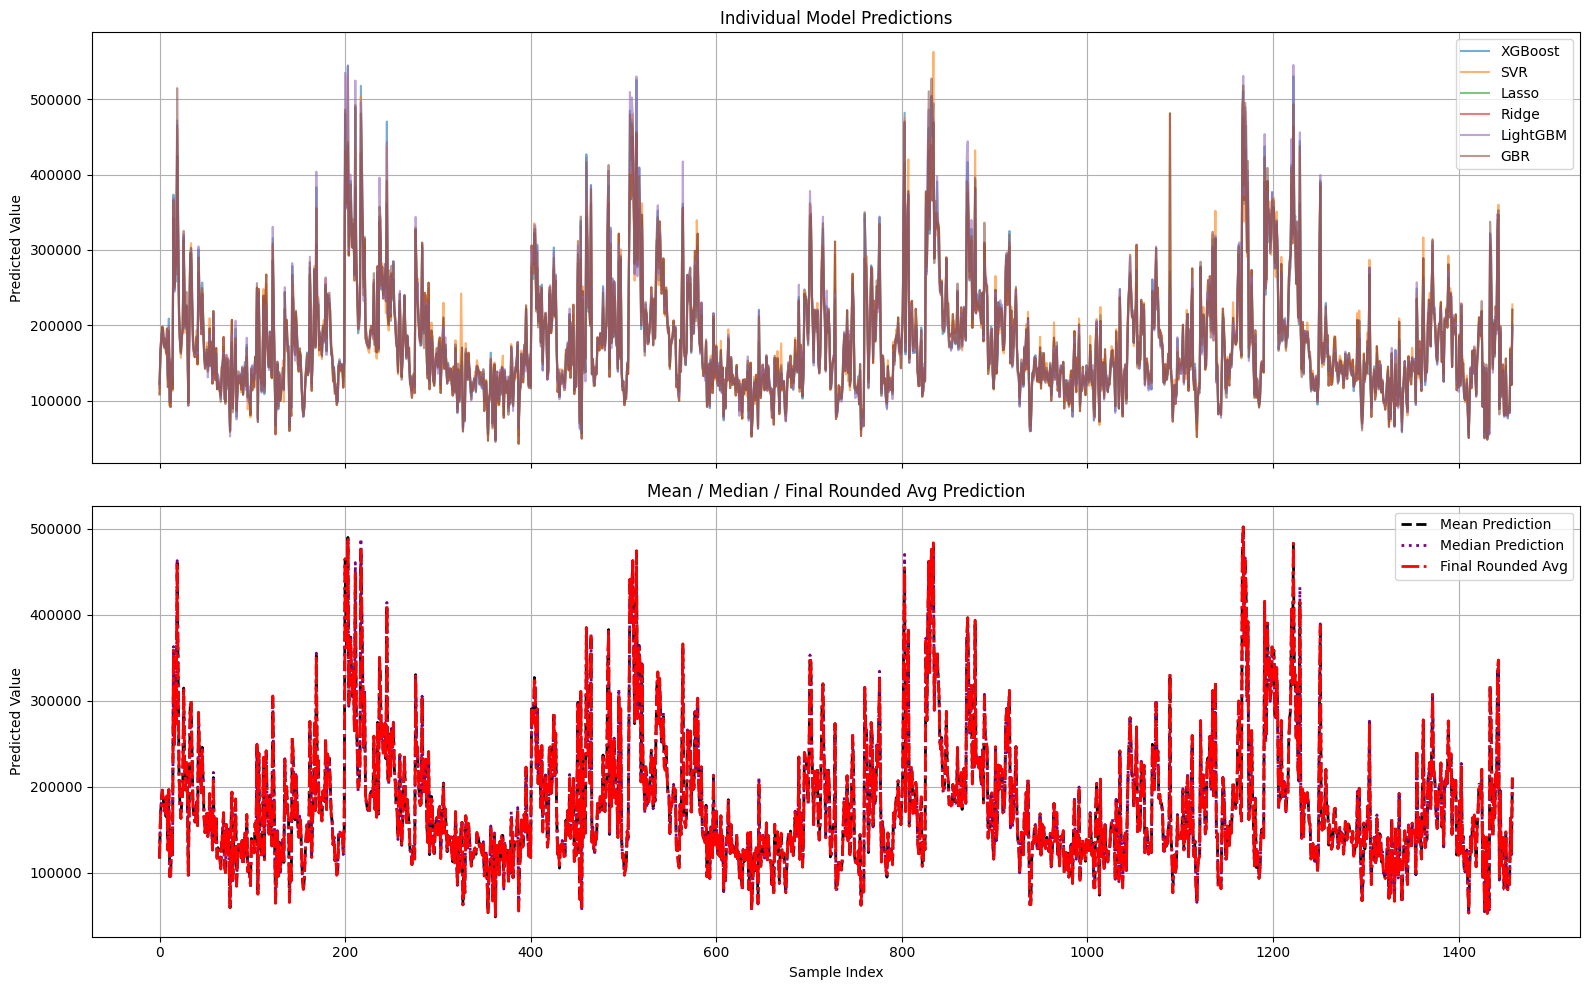

In [155]:
# Stack predictions into a 2D array for easy plotting
all_preds = np.vstack([
    y_pred_xgb_final,
    y_svr_pred_final,
    y_pred_lasso_final,
    y_pred_ridge_final,
    y_pred_lgbm_final,
    y_pred_gbr_final
])
# Labels for legend
model_names = [
    'XGBoost', 'SVR', 'Lasso', 'Ridge', 'LightGBM', 'GBR'
]
# Compute mean and median
mean_pred = all_preds.mean(axis=0)
median_pred = np.median(all_preds, axis=0)

# === Subplots ===
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# --- Subplot 1: All individual model predictions ---
for i, preds in enumerate(all_preds):
    axes[0].plot(preds, label=model_names[i], alpha=0.6)

axes[0].set_title("Individual Model Predictions")
axes[0].set_ylabel("Predicted Value")
axes[0].legend()
axes[0].grid(True)

# --- Subplot 2: Ensemble predictions ---
axes[1].plot(mean_pred, label='Mean Prediction', color='black', linewidth=2, linestyle='--')
axes[1].plot(median_pred, label='Median Prediction', color='purple', linewidth=2, linestyle=':')
axes[1].plot(y_pred_combined_avg, label='Final Rounded Avg', color='red', linewidth=2, linestyle='-.')

axes[1].set_title("Mean / Median / Final Rounded Avg Prediction")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Predicted Value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Seems like no problem with the distritution will be using mean then.

### Averaging them

In [162]:
y_pred_combined_avg = np.round((y_pred_xgb_final +
                       y_svr_pred_final + 
                       y_pred_lasso_final +
                       y_pred_ridge_final + y_pred_lgbm_final + y_pred_gbr_final ) / 6)

### Submission file

In [161]:
import zipfile

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': np.round(y_pred_combined_avg).astype(int)
})
submission.to_csv('submission_all.csv', index=False)
print("✅ Submission file saved as submission_all.csv")

with zipfile.ZipFile('submission_all.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('submission_all.csv')

print("✅ Submission saved as submission_all.zip")


✅ Submission file saved as submission_all.csv
✅ Submission saved as submission_all.zip


## Some Tips on what to do next 

After this we should actually do some Statistics on the model checking about the model biases and on avg how much we should except the deviation in actual price and predicted prices but i say since we can estimate model accuracy just by submitting on kaggle so i won't do it
if you want you can do it. Actually if you do it correctly you can actually improve your score more cannot say just by how much but it will definately help.
I am hinting you on what you can do. so try it if you want:

1) Use confindence interval and bayesian Inference for checking the biasing in the model
   visually you can use histogram to see the distribution(as an overall) but
   There is actually one portion of the sales where i think visual will not help you much for checking the bias. You will be needed to use         those statistical method to find out. Not gonna tell how and which parameter you should be needed to check these. 

2) You might be thinking why checking the bias is important even after we made sure not to do anything in the process to make model bias.<br>
   For this consider an example
   Assume there are 2 states in which prices of lands on each catagory are proportional( features and there catagory are same ) and by some        change you were given the data of only one state since the feature space is same you likely wouldn't be knowing of the proportionality on       two lands and you trained the model on that and then someone used it on the other state and you know what will happen now. Since they are       proportional visual graph may not help you much to figure out what the problem is or how much proportional they are.
      
4) For checking the deviation use 2 sided p-value and then use one sided p-values on each end of the tails of the distribution.
   How you select the distribution and in which way you can use this to improve the score i leave it to you.

### Kaggle Score and Rank for each

| Model        | Score   | Kaggle Rank from Model(best)|
|--------------|---------|-----------------------------|
| XGBoost      | 0.12439 | 638                         |
| SVR          | 0.12619 | No Improvement in Rank      |
| LassoLars    | 0.12692 | No Improvement in Rank      |
| Ridge        | 0.12692 | No Improvement in Rank      |
| LightGBM     | 0.12456 | No Improvement in Rank      |
| GBR          | 0.12118 | 338                         |
| Combined(avg)| 0.11839 | 152                         |
| Combined(avg) roundoff (2digit)| 0.11838| 152 (No change)|
| Combined(avg) roundoff (3digit)| 0.11830|  144|
| Combined(avg) 250 n_trails|0.11813|135 (BEST)|


## Notebook Created by:

#### Kaustuk Pratap Singh